In [1]:
device = 'cuda:1'

In [2]:
#import matplotlib as mpl
# Use the pgf backend (must be set before pyplot imported)
#mpl.use('pgf')

#import matplotlib.pyplot as plt

#plt.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    "font.family": "serif",  # use serif/main font for text elements
#    "text.usetex": True,     # use inline math for ticks
#    "pgf.rcfonts": False     # don't setup fonts from rc parameters
#    })


In [3]:
import numpy as np
import copy
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from include import *
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio
PSNR= peak_signal_noise_ratio
import bm3d

In [4]:
def crop_center(img):    
    new_width=256
    new_height=256

    width, height = img.size   # Get dimensions

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    
    return np.array(img)

def add_noise(img, sigma):
    np.random.seed(1)
    noise = np.float32(np.random.normal(0, sigma/255, (256,256))) 
    noisy_img=np.clip(img+noise,0,1)
    
    return noisy_img

In [5]:
img = Image.open('./car.png').convert('L')
img = crop_center(img)

clean_img = np.float32(img/np.max(img)) 
noisy_img = add_noise(clean_img, 30)

<Figure size 432x288 with 0 Axes>

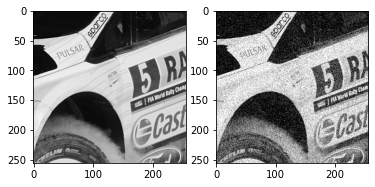

In [6]:
plt.gray()
f, plots = plt.subplots(1,2)
plots[0].imshow(clean_img)
plots[1].imshow(noisy_img)

In [7]:
noisy_img = torch.FloatTensor(noisy_img).to(device)
clean_img = torch.FloatTensor(clean_img).to(device)

noise = noisy_img - clean_img
noise = noise*torch.norm(clean_img)/torch.norm(noise) * 0.5 #####################

noisy_img= clean_img + noise #########################################

torch.manual_seed(1)
Input = torch.rand((1,1,256,256)).to(device)

In [8]:
model_a = Unet_Mixer_noU().to(device)
model_b = copy.deepcopy(model_a)
model_c = copy.deepcopy(model_a)

In [9]:
##Functions

##Loss
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

#train
def train(model, optimizer, Input, clean_img, noisy_img):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()
    
    # get the prediction
    pred = model(Input)
    #pred = torch.clamp(pred,0,1)

    mse_noisy = mse(pred, noisy_img.unsqueeze(0).unsqueeze(0))
    mse_clean = mse(pred, clean_img.unsqueeze(0).unsqueeze(0))
    
    #one step of training
    mse_noisy.backward()
    optimizer.step()

    return mse_noisy.item(), mse_clean.item()


def fit(model, optimizer, Input, img):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()
    
    # get the prediction
    pred = model(Input)
    #pred = torch.clamp(pred,0,1)

    mse_pred = mse(pred, img.unsqueeze(0).unsqueeze(0))
    
    #one step of training
    mse_pred.backward()
    optimizer.step()

    return mse_pred.item()


In [10]:
# fitting noisy image

max_epoch = 1501
lr = 0.0001
decay_step = 500
decay_gamma = 0.5
iterations=[0,10,50,100,700,1100,1500]



optimizer = optim.Adam(model_a.parameters(), lr=lr, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_gamma)

denoised= []
mse_noisy=[]
mse_clean=[]
err=999999


for i in range(max_epoch):
    
    a,b = train(model_a, optimizer, Input, clean_img, noisy_img)
    
    mse_noisy.append(a)
    mse_clean.append(b)
    
    scheduler.step()
    
    with torch.no_grad(): 
        if i in iterations:
            denoised.append(model_a(Input).squeeze(0).squeeze(0))

        if b<err:
            err = b
            best = model_a(Input).squeeze(0).squeeze(0)
            best_i=i

    if i%50 == 0:
        print(i, a,b, end='\r')
        


In [11]:
#fitting clean image

optimizer = optim.Adam(model_b.parameters(), lr=lr, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_gamma)

clean=[]


for i in range(max_epoch):
    
    err = fit(model_b, optimizer, Input, clean_img)
    clean.append(err)

    scheduler.step()
    
    if i%50 == 0:
        print(i, err, end='\r')

In [12]:
#fitting noise

optimizer = optim.Adam(model_c.parameters(), lr=lr, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_gamma)

noisy=[]


for i in range(max_epoch):
    
    err = fit(model_c, optimizer, Input, noise)
    noisy.append(err)

    scheduler.step()
    
    if i%50 == 0:
        print(i, err, end='\r')

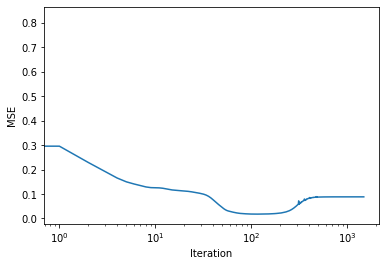

In [13]:
#mse_clean.insert(0,mse_clean[0])
t=0
x=np.arange(max_epoch)
plt.plot(x[t:],mse_clean[t:])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.xscale("log")

#plt.savefig('mixer-noisy_img.pgf', format='pgf')

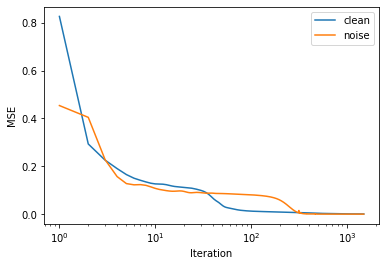

In [14]:
#noisy.insert(0,noisy[0])
#clean.insert(0,clean[0])

x=np.arange(1,max_epoch+1)
plt.plot(x,clean, label ='clean')
plt.plot(x,noisy, label = 'noise')
plt.xscale("log")
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()


#plt.savefig('mixer-CleanvsNoise.pgf', format='pgf')

In [15]:
for j in range (len(iterations)):
    if best_i<iterations[j]:
        break

denoised.insert(j,best)
iterations = np.insert(iterations,j,best_i)

L=len(iterations)

In [16]:
bm3d_img = np.clip(bm3d.bm3d(noisy_img.cpu().numpy(), 30/255),0,1).astype('float32')

In [17]:
psnr=[]

for i in range(L):
    restored=np.clip(denoised[i].cpu().numpy(),0,1)
    psnr.append(PSNR(restored,clean_img.cpu().numpy()))

psnr.append(PSNR(bm3d_img, clean_img.cpu().numpy()))    

Text(0.5, 1.0, 'Clean Image')

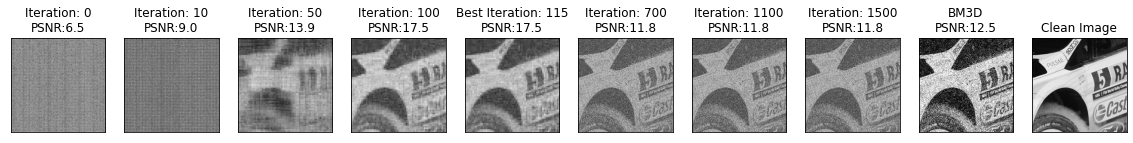

In [18]:
fig, ax = plt.subplots(1, L+2,figsize=(20, 20))
for i in range(L):
    ax[i].imshow(denoised[i].cpu().numpy())
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    if i == j:
        ax[i].set_title('Best Iteration: '+ str(iterations[i])+'\n' +'PSNR:' +str(np.around(psnr[i],1)))
    else:
        ax[i].set_title('Iteration: '+ str(iterations[i])+'\n' +'PSNR:' +str(np.around(psnr[i],1)))
        

ax[L].imshow(bm3d_img)
ax[L].set_xticks([])
ax[L].set_yticks([])
ax[L].set_title('BM3D'+'\n' +'PSNR:' +str(np.around(psnr[L],1)))

ax[L+1].imshow(clean_img.cpu().numpy())
ax[L+1].set_xticks([])
ax[L+1].set_yticks([])
ax[L+1].set_title('Clean Image')


#plt.savefig('mixer-iters.pgf', format='pgf')    

In [19]:
###Save plots

y = mse_clean
data = np.array([np.arange(1,len(y)+1), y]).T
np.savetxt('mixer_noisy_img.dat', data, delimiter=' ', newline='\n', header='x y', comments='')

y = clean
data = np.array([np.arange(1,len(y)+1), y]).T
np.savetxt('mixer_clean.dat', data, delimiter=' ', newline='\n', header='x y', comments='')

y = noisy
data = np.array([np.arange(1,len(y)+1), y]).T
np.savetxt('mixer_noise.dat', data, delimiter=' ', newline='\n', header='x y', comments='')

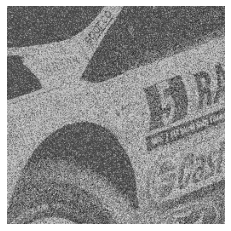

In [20]:
##Save imgs
for i in range(L):
    plt.imshow(denoised[i].cpu().numpy())
    plt.axis('off')
    plt.savefig('mixer_iter_'+str(i)+'.png', format='png', bbox_inches='tight')

In [21]:
np.min(mse_clean)

0.017849639058113098